In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
df = pd.read_json("gme.json")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5600 non-null   datetime64[ns]
 1   Open       5600 non-null   float64       
 2   High       5600 non-null   float64       
 3   Low        5600 non-null   float64       
 4   Close      5600 non-null   float64       
 5   Adj Close  5600 non-null   float64       
 6   Volume     5600 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 306.4 KB


Date - The day we observed the stock.
Open - The price of the stock the market opens.
High - The highest recorded price of the stock for the day. 
Low - The lowest recorded priice of the stock for the day.
Close - The price of the stock when the market closes.
Adj Close - The adjusted price of a stock when the market closes. 
Volume - The number of the stocks being traded in a single day.

In [4]:
df[df["High"] == df["High"].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
4772,2021-01-28,66.25,120.75,28.0625,48.400002,48.400002,235263200


In [15]:
count = 0
total = 0
for month in range(1, 13):
    for i in range(len(df)):
        if df.loc[i]["Date"].month == month:
            avg = (df.loc[i]["High"] + df.loc[i]["Low"]) / 2
            total += avg
            count += 1
total/count

9.48407867025863

In [17]:
df.loc[0]["Date"].day

13

<AxesSubplot:xlabel='Volume', ylabel='Low'>

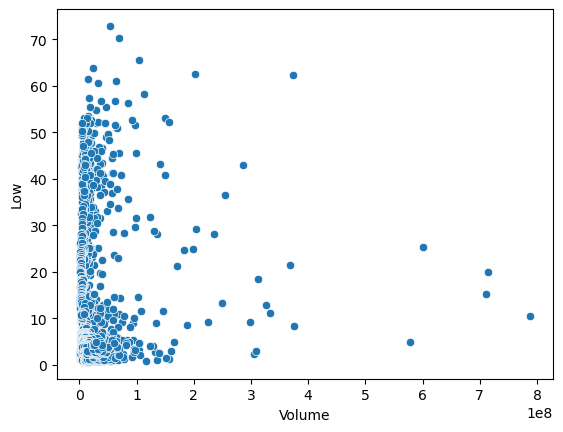

In [20]:
sns.scatterplot(data=df, x="Volume", y="Low")

In [19]:
df["Low"].corr(df["Volume"])

0.10259646883179027

After examining the scatterplot for Low vs. Volume, there appears to be no relationship between these variables. To confirm this, I calculated the Pearsono correlation coefficient and my hunch was right! The correlation coefficient is 0.1, which means that the direction of this relationship is positive and its strength is very weak. In conclusion, there is no relationship between the Low of the day and the Volume of stock being traded. 

<AxesSubplot:xlabel='Date', ylabel='High'>

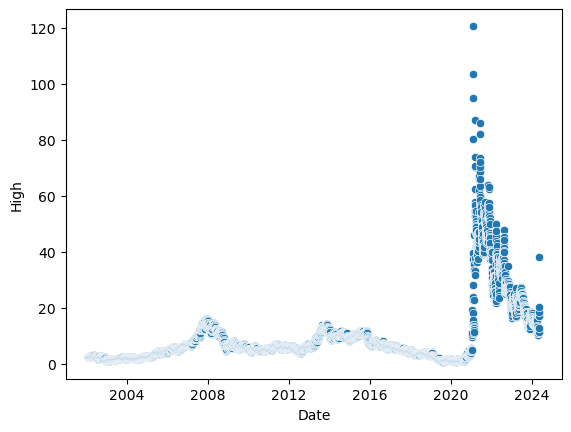

In [21]:
sns.scatterplot(data=df, x="Date", y="High")

In [23]:
log_high = np.log(df["High"])

In [24]:
df["Log High"] = log_high

<AxesSubplot:xlabel='Date', ylabel='Log High'>

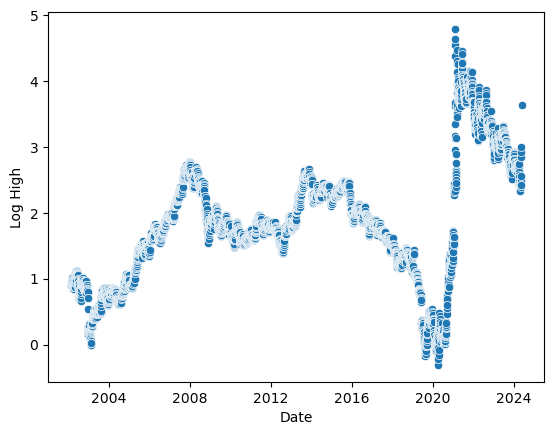

In [26]:
sns.scatterplot(data=df, x="Date", y="Log High")

In [27]:
df['numeric_time'] = pd.to_datetime(df['Date']).astype('int64') // 10**9  # Converts to seconds since epoch

# Now you can calculate the Pearson correlation between 'numeric_time' and another variable
correlation = df['numeric_time'].corr(df['Log High'])

In [28]:
correlation

0.45097470030936626

In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [14]:
years = {} # .keys(), .values(), .items()
for i in range(len(df)):
    year = df.loc[i]["Date"].year
    if year not in years.keys() and year != 2024:
        years[year] = 1
    elif year in years.keys() and year != 2024:
        years[year] += 1
sum(years.values())/len(years)

250.36363636363637

In [21]:
url = 'https://api.polygon.io/v1/open-close/GME/2024-05-14?adjusted=false&apiKey=pqM3pnssdX3a9Ps3whjdxguDpbElVPfg'
r = requests.get(url)
data = r.json()

print(data)

{'status': 'OK', 'from': '2024-05-14', 'symbol': 'GME', 'open': 64.83, 'high': 64.83, 'low': 36, 'close': 48.75, 'volume': 206973629.0, 'afterHours': 51, 'preMarket': 40.31}


In [72]:
def gather_data(start, end):
    '''
    Request a json payload from Polygon.io for each day within the timeframe, described by
    {start} and {end}.
    Once I get json for a day, I need to add it to a dictionary before returning the dataframe.
    '''
    # Create dictionary for final dataframe
    data = {"Date": [],"Open": [],"High": [],"Low": [],"Close": [],"Volume": []}
    
    # Get the month as a number to iterate through timespan
    startMonth = pd.to_datetime(start).month
    endMonth = pd.to_datetime(end).month
    
    # Iterate through timespan
    for month in range(startMonth, endMonth + 1):
        # Get most of days in month
        for day in range(1, 26):
            # Create string of date for URL
            if day < 10:
                current = '2024-0' + str(month) + '-0' + str(day)
            else:
                current = '2024-0' + str(month) + '-0' + str(day) 
            
            # Make request
            url = 'https://api.polygon.io/v1/open-close/GME/' + current + '?adjusted=false&apiKey=pqM3pnssdX3a9Ps3whjdxguDpbElVPfg'
            r = requests.get(url)
            jsonData = r.json()
            
            # Add date-specific data to dictionary
            data["Open"].append(jsonData['open'])
            data["High"].append(jsonData['high'])
            data["Low"].append(jsonData["low"])
            data["Close"].append(jsonData['close'])
            data["Volume"].append(jsonData['volume'])
            date = pd.to_datetime(current)
            data["Date"].append(date)
    
        # Remove break statements if you want to make multiple requests
            break
        break
    
    # return dataframe of data
    return pd.DataFrame(data)

In [73]:
gather_data('2024-05-14', '2024-09-26')

,Date,Open,High,Low,Close,Volume
0,2024-05-01,11.03,11.32,10.7,10.91,2631514.0


In [4]:
# Reading in more recent GME data
df2 = pd.read_json("recentGME.json")
df.drop(["Adj Close"], inplace=True, axis=1)
# Adding new data to the bottom of the OG GME dataframe
result = pd.concat([df, df2])
result.reset_index(inplace=True)

In [16]:
# Get AMC data using Polygon.io
url = 'https://api.polygon.io/v1/open-close/AMC/2024-08-21?adjusted=false&apiKey=pqM3pnssdX3a9Ps3whjdxguDpbElVPfg'
r = requests.get(url)
data = r.json()

print(data)

{'status': 'OK', 'from': '2024-08-21', 'symbol': 'AMC', 'open': 4.99, 'high': 5.06, 'low': 4.98, 'close': 5.01, 'volume': 5322396.0, 'afterHours': 5, 'preMarket': 5.01}


In [17]:
amc = pd.read_csv("AMC.csv")

In [19]:
amc.drop(["Adj Close"], inplace=True, axis=1)

In [24]:
amc["Date"] = pd.to_datetime(amc["Date"])

In [25]:
type(amc.loc[0]["Date"])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:title={'center':'Comparison of GME and AMC stock over time'}, xlabel='Date', ylabel='High'>

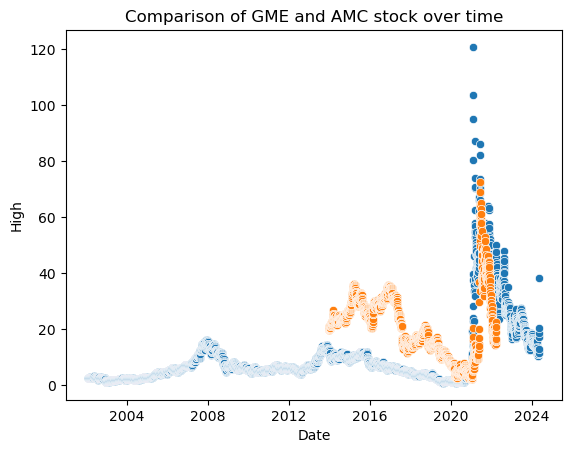

In [28]:
sns.scatterplot(data=df, x="Date", y="High").set_title("Comparison of GME and AMC stock over time")
sns.scatterplot(data=amc, x="Date", y="High")

# How to make this graph more readable?
1. Trim the GME dataset so that it only includes dates that match the AMC data.
2. Give your graphs a descriptive title
3. Include a legend that describes what each color means.
4. Be intentional about color! For example, make shared values a different color.

In [29]:
wsb = pd.read_json("light_encode_wsb.json")
wsb.head()

,label,timestamp,score,comms_num
0,AMC,2021-01-28,38408,6027
1,AMC,2021-01-29,22404,7023
2,AMC,2021-01-30,66084,11660
3,AMC,2021-01-31,54180,6934
4,AMC,2021-02-01,122882,8710


In [33]:
wsb.rename(columns={"timestamp":"Date"}, inplace=True)

In [39]:
amc_wsb = wsb[wsb["label"] == "AMC"]
amc_wsb["label"].unique()

array(['AMC'], dtype=object)

In [40]:
merged_amc = pd.merge(amc, amc_wsb, how="inner", on="Date")

In [41]:
merged_amc.head()

,Date,Open,High,Low,Close,Volume,label,score,comms_num
0,2021-01-28,11.98,16.50,6.51,8.63,591223900,AMC,38408,6027
1,2021-01-29,14.31,16.00,11.60,13.26,602193300,AMC,22404,7023
2,2021-02-01,17.00,17.25,12.91,13.30,434608000,AMC,122882,8710
3,2021-02-02,9.48,10.10,6.00,7.82,462775900,AMC,16928,3338
4,2021-02-03,8.85,9.77,7.89,8.97,221405100,AMC,97207,7629


In [48]:
merged_amc["comms_num_log"] = np.log(merged_amc["comms_num"])

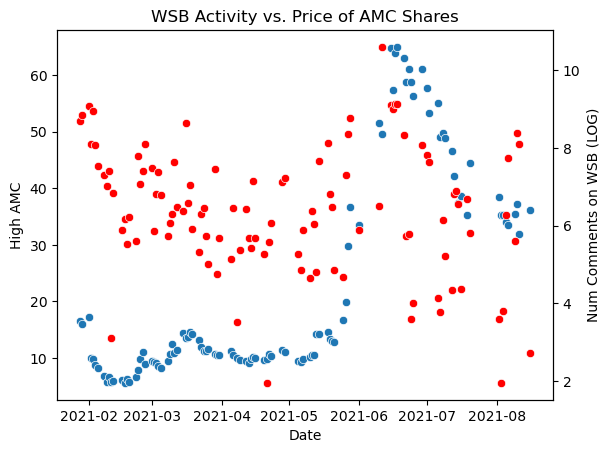

In [53]:
import matplotlib.pyplot as plt
ax1 = sns.scatterplot(data=merged_amc, x="Date", y="High")
ax2 = ax1.twinx()
sns.scatterplot(data=merged_amc, x='Date', y='comms_num_log', ax=ax2, color='red')

# Set labels and titles
ax1.set_ylabel('High AMC')
ax2.set_ylabel('Num Comments on WSB (LOG)')
plt.title('WSB Activity vs. Price of AMC Shares')

plt.show()

<AxesSubplot:xlabel='Date', ylabel='High'>

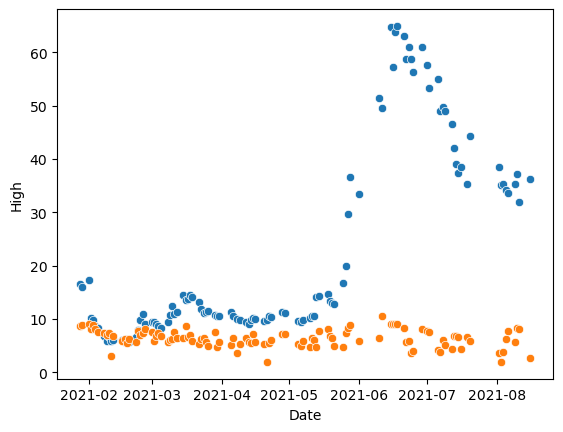

In [51]:
sns.scatterplot(data=merged_amc, x="Date", y="High")
sns.scatterplot(data=merged_amc, x="Date", y="comms_num_log")